In [4]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [7]:
# define constants and other parameters
K = 3.2e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
# Q = r * A

In [8]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 10
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    # ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        # ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma)) #- ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta) # removed ql

In [10]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta) = model(*test_run) #removed ql

50000000.0


In [11]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

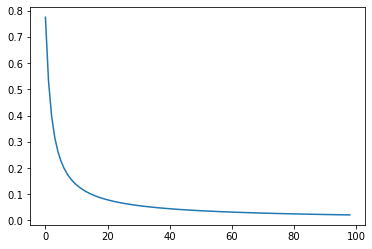

In [12]:
plt.plot(S)

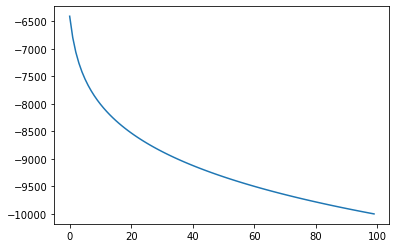

In [13]:
plt.plot(eta)

In [14]:
S[-1]

0.02111477742595889

In [15]:
eta

array([-6410.05791871, -6797.30194304, -7062.74588544, -7261.19269252,
       -7419.5212757 , -7551.42323118, -7664.69063225, -7764.14373825,
       -7852.95667485, -7933.3232128 , -8006.81931173, -8074.61353906,
       -8137.59563142, -8196.45843265, -8251.7520001 , -8303.92042848,
       -8353.32757506, -8400.2754472 , -8445.01761391, -8487.76916648,
       -8528.7142374 , -8568.01176022, -8605.79994147, -8642.19977537,
       -8677.31783733, -8711.24852742, -8744.07588919, -8775.87509735,
       -8806.71368447, -8836.65256023, -8865.74686417, -8894.04668383,
       -8921.59766332, -8948.44152173, -8974.61649736, -9000.15773004,
       -9025.09759186, -9049.46597441, -9073.29053937, -9096.59693786,
       -9119.4090033 , -9141.74892138, -9163.63738046, -9185.09370512,
       -9206.13597488, -9226.7811303 , -9247.04506782, -9266.94272491,
       -9286.48815662, -9305.69460461, -9324.57455944, -9343.13981703,
       -9361.40152988, -9379.37025354, -9397.05598899, -9414.46822132,
      

In [16]:
eta_adj = eta - eta[-1]

In [17]:
eta_adj

array([3589.34208287, 3202.09805854, 2936.65411614, 2738.20730906,
       2579.87872588, 2447.9767704 , 2334.70936933, 2235.25626332,
       2146.44332673, 2066.07678878, 1992.58068985, 1924.78646251,
       1861.80437016, 1802.94156893, 1747.64800148, 1695.4795731 ,
       1646.07242652, 1599.12455438, 1554.38238767, 1511.6308351 ,
       1470.68576418, 1431.38824136, 1393.6000601 , 1357.20022621,
       1322.08216425, 1288.15147416, 1255.32411239, 1223.52490423,
       1192.68631711, 1162.74744134, 1133.65313741, 1105.35331775,
       1077.80233826, 1050.95847985, 1024.78350422,  999.24227153,
        974.30240972,  949.93402716,  926.10946221,  902.80306371,
        879.99099827,  857.6510802 ,  835.76262112,  814.30629646,
        793.26402669,  772.61887128,  752.35493376,  732.45727667,
        712.91184495,  693.70539697,  674.82544214,  656.26018455,
        637.9984717 ,  620.02974804,  602.34401259,  584.93178026,
        567.7840466 ,  550.89225544,  534.24826927,  517.84434

In [18]:
# save csv files

np.savetxt('elevation csv files/eta_exp_3_1D.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_3_1D.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_3_1D.csv', S, delimiter = ',')

In [19]:
# calc width

b = (kb * Q[1:] * S**(7/6)) / (D**(3/2))

np.savetxt('width csv files/b_exp_3_1D.csv', b, delimiter = ',')
np.savetxt('Qs csv files/Qs_exp_3_1D.csv', Qs, delimiter = ',')